In [79]:
import tensorflow as tf

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers


from tensorflow.keras.layers import Input


import pandas as pd

data = pd.read_csv("PRSA_data_2010.1.1-2014.12.31.csv")

In [82]:
def mean_absolute_percentage_error(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [75]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads

def gradient_weight(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grad = tape.gradient(predictions, seq)
    #gr=grads
    #grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grad

def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

In [4]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


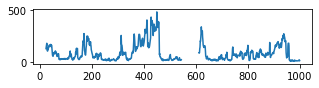

In [5]:
plt.figure(figsize=(5,1))
plt.plot(data['pm2.5'][:1000])

In [6]:
data['cbwd']=data['cbwd'].factorize()[0]

In [7]:
data['pm2.5'] = data['pm2.5'].fillna(method='ffill').fillna(method='bfill')

In [8]:
data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,129.0,-21,-11.0,1021.0,0,1.79,0,0
1,2,2010,1,1,1,129.0,-21,-12.0,1020.0,0,4.92,0,0
2,3,2010,1,1,2,129.0,-21,-11.0,1019.0,0,6.71,0,0
3,4,2010,1,1,3,129.0,-21,-14.0,1019.0,0,9.84,0,0
4,5,2010,1,1,4,129.0,-20,-12.0,1018.0,0,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,0,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,0,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,0,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,0,246.72,0,0


In [7]:
data.columns[5:]

Index(['pm2.5', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir'], dtype='object')

In [9]:
from sklearn.preprocessing import MinMaxScaler
values = data[data.columns[5:]].values.reshape(-1,8)
values = values.astype('float32')
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
scaled = (values-(np.min(values)))/(np.max(values)-(np.min(values)))

In [10]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test,test1 = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:],scaled[train_size:,]
print(len(train),len(val), len(test),len(test1))

35059 4382 4383 8765


In [11]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [12]:
look_back = 24
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)
test1X, test1Y = create_dataset_mul(test1, look_back)

35035
4358
4359
8741


In [13]:
print(trainX.shape)
print(trainY.shape)

(35035, 24, 8)
(35035,)


### MTEX



##참고

https://github.com/duyanhpham-brs/XAI-Multivariate-Time-Series/blob/develop/utils/training_helpers/__init__.py  

In [88]:
first_input = Input(shape=(24,8,1))

in0=Conv2D(filters=16, kernel_size=(24//3,1),input_shape=(24,8,1), activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

in1=Conv2D(filters=32, kernel_size=(24//5,1), activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv2D(filters=1, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)
print(in1.shape)
in1 = Reshape((24,8))(in1)
in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=Conv1D(filters=64, kernel_size=2, activation='relu',padding='same')(in0)
#in0= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

#in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same',name='extractor')(in1)
#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=add([in0,in1])
in1=Flatten()(in0)
#in1=Dense(50, activation='relu')(in1)
#in1=LSTM(64)(in1)
in1 = Dense(32,activation='relu')(in1)

out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/pm2.5_MTEX_onestep.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
model.summary()
# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

(?, 24, 8, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 24, 8, 1)          0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 24, 8, 16)         144       
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 24, 8, 32)         2080      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 24, 8, 1)          33        
_________________________________________________________________
reshape_15 (Reshape)         (None, 24, 8)             0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24, 64)            1600      
_________________________________________________________________
flatten_6 (Flatten)          (None, 1536)              0      

In [89]:
trainX = trainX.reshape(-1,24,8,1)
testX = testX.reshape(-1,24,8,1)
valX = valX.reshape(-1,24,8,1)

In [90]:
history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 35035 samples, validate on 4358 samples
Epoch 1/200
34800/35035 [============================>.] - ETA: 0s - loss: 0.0027
Epoch 00001: val_loss improved from inf to 0.00061, saving model to saved_weights/pm2.5_MTEX_onestep.hdf5
35035/35035 [==============================] - 9s 255us/sample - loss: 0.0027 - val_loss: 6.1441e-04
Epoch 2/200
35000/35035 [============================>.] - ETA: 0s - loss: 5.9083e-04
Epoch 00002: val_loss improved from 0.00061 to 0.00058, saving model to saved_weights/pm2.5_MTEX_onestep.hdf5
35035/35035 [==============================] - 7s 210us/sample - loss: 5.9039e-04 - val_loss: 5.7988e-04
Epoch 3/200
34900/35035 [============================>.] - ETA: 0s - loss: 5.3522e-04
Epoch 00003: val_loss improved from 0.00058 to 0.00051, saving model to saved_weights/pm2.5_MTEX_onestep.hdf5
35035/35035 [==============================] - 8s 215us/sample - loss: 5.3432e-04 - val_loss: 5.1115e-04
Epoch 4/200
34800/35035 [============================>.] - E

Epoch 33/200
35000/35035 [============================>.] - ETA: 0s - loss: 4.3574e-04
Epoch 00033: val_loss did not improve from 0.00047
35035/35035 [==============================] - 10s 282us/sample - loss: 4.3543e-04 - val_loss: 5.1778e-04
Epoch 34/200
35000/35035 [============================>.] - ETA: 0s - loss: 4.3716e-04
Epoch 00034: val_loss did not improve from 0.00047
35035/35035 [==============================] - 10s 285us/sample - loss: 4.3689e-04 - val_loss: 4.8518e-04
Epoch 35/200
35000/35035 [============================>.] - ETA: 0s - loss: 4.4021e-04
Epoch 00035: val_loss did not improve from 0.00047
35035/35035 [==============================] - 10s 285us/sample - loss: 4.3999e-04 - val_loss: 5.7289e-04
Epoch 36/200
34900/35035 [============================>.] - ETA: 0s - loss: 4.4171e-04
Epoch 00036: val_loss did not improve from 0.00047
35035/35035 [==============================] - 10s 287us/sample - loss: 4.4110e-04 - val_loss: 4.8483e-04
Epoch 37/200
35000/35035

KeyboardInterrupt: 

In [91]:
model.load_weights("saved_weights/pm2.5_MTEX_onestep.hdf5")

In [92]:
X_test.shape

(4359, 24, 8)

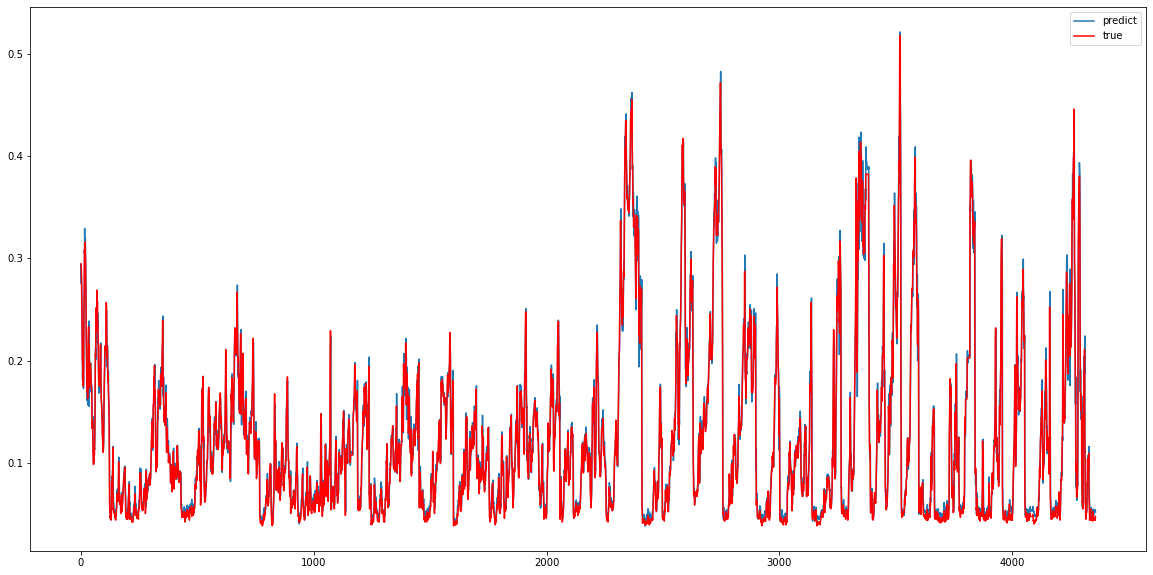

Test RMSE: 0.01658
Test MAE: 0.00986
Test MSE: 0.00028
Test MAPE: 9.53479
Test RMSE: 18.01014
Test MAE: 10.70489
Test MAPE: 26.95069


In [104]:
#1dcnn(5,1)-lstm

from sklearn.metrics import *

from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

mape=mean_absolute_percentage_error(testY, np.array(yhat).reshape(1,-1))
print('Test MAPE: %.5f' % mape)



yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

rmse = sqrt(mean_squared_error(np.array(yhat_inverse), testY_inverse))
mae=mean_absolute_error(np.array(yhat_inverse), testY_inverse)
mape=mean_absolute_percentage_error(testY_inverse,np.array(yhat_inverse).reshape(1,-1))

print('Test RMSE: %.5f' % rmse)
print('Test MAE: %.5f' % mae)
print('Test MAPE: %.5f' % mape)


In [94]:
testY_inverse

array([280., 277., 274., ...,  10.,   8.,  12.], dtype=float32)

In [97]:
np.array(yhat_inverse.reshape(1,-1))


array([[259.58972 , 279.53687 , 266.52853 , ...,  18.872272,  18.705357,
         16.788044]], dtype=float32)